# Etape 1: Creation du DataSet

Essential imports:

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from utilities import categorize_column, plot_PCA, plot_cumulative_explained_variance, COLORS

Loading base dataset:

In [33]:
#df_3features=pandas.read_csv("./datasets/Stress_temperature_step_humidity.csv", sep =',')
#df_sleep=pandas.read_csv("./datasets/sayopillow/SaYoPillow.csv", sep =',')

df=pd.read_csv("./datasets/Sleep_health.csv", sep =',')

In [34]:
columns_to_check = ['Sleep Disorder', 'Sleep Duration', 
                    'Quality of Sleep', 'Stress Level', 
                    'Physical Activity Level', 'Heart Rate', 
                    'Daily Steps']

for column in columns_to_check:
    unique_values = df[column].unique()
    values_str = ', '.join(map(str, unique_values))
    print(f'{column} : {values_str}')

Sleep Disorder : nan, Sleep Apnea, Insomnia
Sleep Duration : 6.1, 6.2, 5.9, 6.3, 7.8, 6.0, 6.5, 7.6, 7.7, 7.9, 6.4, 7.5, 7.2, 5.8, 6.7, 7.3, 7.4, 7.1, 6.6, 6.9, 8.0, 6.8, 8.1, 8.3, 8.5, 8.4, 8.2
Quality of Sleep : 6, 4, 7, 5, 8, 9
Stress Level : 6, 8, 7, 4, 3, 5
Physical Activity Level : 42, 60, 30, 40, 75, 35, 45, 50, 32, 70, 80, 55, 90, 47, 65, 85
Heart Rate : 77, 75, 85, 82, 70, 80, 78, 69, 72, 68, 76, 81, 65, 84, 74, 67, 73, 83, 86
Daily Steps : 4200, 10000, 3000, 3500, 8000, 4000, 4100, 6800, 5000, 7000, 5500, 5200, 5600, 3300, 4800, 7500, 7300, 6200, 6000, 3700


### 1. DESCRIPTION DES FEATURES ###  

**Features déjà presentes dans le dataset initial**   
Gender : Male or Female (**Initial Data from individual**)  
Age : Age of the induvidual (**Initial Data from individual**)  
Sleep Duration : in hours decimal (**Watch**)  
Quality of Sleep : Assessed on a 0-10 scale (**assessed by questionnaire (or watch**))   
Physical Activity Level : number of minutes spent exercising during the day (**watch or questionnaire**)  
Heart Rate : BPM nominale (**Initial Data from individual (or rate mesured during the night by watch)**)  
Daily Steps : number of steps during the day (**watch**)  
Sleep Disorder : [Regular, Sleep Apnea, Insomnia'] (**Initial Data from individual**)  

**Features à ajouter dans le dataset**  
irritation level : Assessed on a 0-10 scale (**assessed by questionnaire**)  
Control level : Assessed on a 0-10 scale (**assessed by questionnaire**)  
Emotion Control level : Assessed on a 0-10 scale (**assessed by questionnaire**)  
Heart mean day : mean of BPM during the day (**watch**) 

**Target**  
Stress Level : Target feature (1 - not stressed, 2 - regular, 3 - stressed)    

### 2. Transformation des données du dataset initial ###  
Utilisation d'un pipeline

In [35]:
def sleep_disorder_to_bool(df):
    df['Sleep Disorder'] = df['Sleep Disorder'].map({'Sleep Apnea': True, 'Insomnia': True})
    df['Sleep Disorder'] = df['Sleep Disorder'].fillna(False, inplace= False)
    return df

def gender_to_bool(df):
    df_copy = df.copy()
    df_copy['Gender'] = df_copy['Gender'].map({'Male': True, 'Female': False})
    return df_copy

# Effectue des transformations sur 'df' qui doit contenir les features initiales
def data_transform_base(df): 
    ### IRITATION LEVEL ###
    df['Irritation Level'] = (( df['Stress Level'] + (10 - df['Quality of Sleep']))  
                                // 2 + np.random.choice([-2, -1, 0, 1, 2], len(df)))
    df['Irritation Level'] = np.clip(df['Irritation Level'], 0, 10) # between 0 and 10

    
    ### LIFE CONTROL LEVEL ###
    df['Life Control Level'] =((10 - df['Stress Level']) + 
                               np.random.choice([-2, -1, 0, 1, 2], len(df)))
    df['Life Control Level'] = np.clip(df['Life Control Level'], 0, 10) # between 0 and 10

    
    ### EMOTION CONTROL LEVEL ###
    df['Emotion Control Level'] =(((df['Physical Activity Level'] / 9)  + 
                                   (10 - df['Stress Level']))  // 2 + 
                                  np.random.choice([-2, -1, 0, 1, 2], len(df)))
    df['Emotion Control Level'] = np.clip(df['Emotion Control Level'], 0, 10) # between 0 and 10


    ### MAX HEART RATE ###
    df['Mean Heart Rate'] = (df['Heart Rate'] + 
                             np.maximum(5, ((df['Stress Level'] - 5) + 
                            ((df['Physical Activity Level']) * 5 / df['Physical Activity Level'].max()))) + 
                             np.random.choice([-2, -1, 0, 1, 2], len(df)))
    
    
    ### BPM DIFFERENCE ###
    df['BPM diff'] = df['Mean Heart Rate'] - df['Heart Rate'] 

    
    ### DROP COLUMNS ###
    columns_to_delete = ["Person ID", "Occupation", 
                         "Blood Pressure", "BMI Category", 
                         "Mean Heart Rate", "Heart Rate"]
    df.drop(columns= columns_to_delete, axis= 1, inplace= True)
    
    return df

def scale_data(df):
    scaler = StandardScaler()

    # Columns to scale
    columns_to_scale = [col for col in df.columns if col not in ['Stress Level', 'Sleep Disorder', 'Gender']]

    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df

def transform_stress_level(df):
    stress_mapping = {'Not Stressed': 0, 'Slighly Stressed': 1, 'Stressed': 2}
    df['Stress Level'] = df['Stress Level'].map(stress_mapping)
    return df

In [36]:
int_bins = [0, 4, 7, 11]
categorial_labels = ['Not Stressed', 'Slighly Stressed', 'Stressed']

categorize_column_transformer = FunctionTransformer(lambda x: categorize_column(x, 'Stress Level', int_bins, categorial_labels, inplace= False))

In [37]:
pipeline = Pipeline([
    ('sleep_disorder_to_bool', FunctionTransformer(sleep_disorder_to_bool)),
    ('gender_to_bool', FunctionTransformer(gender_to_bool)),
    ('data_transform_base', FunctionTransformer(data_transform_base)),
    ('scale_data', FunctionTransformer(scale_data)),
    ('categorize_column', categorize_column_transformer),
    ('transform_stress_level', FunctionTransformer(transform_stress_level))
])

In [38]:
df=pd.read_csv("./datasets/Sleep_health.csv", sep =',')

In [39]:
df_transformed = pipeline.fit_transform(df)

In [40]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,False
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,False
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,False
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,True
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,True


In [41]:
df_transformed.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Daily Steps,Sleep Disorder,Irritation Level,Life Control Level,Emotion Control Level,BPM diff
0,True,-1.753096,-1.298887,-1.098280,-0.825418,1,-1.619584,False,1.649693,-0.295054,-1.048022,-1.338518
1,True,-1.637643,-1.173036,-1.098280,0.039844,2,1.970077,False,2.161714,-0.729503,-1.519128,1.716284
2,True,-1.637643,-1.173036,-1.098280,0.039844,2,1.970077,False,1.649693,-1.163952,0.365296,0.570733
3,True,-1.637643,-1.550588,-2.771424,-1.402260,2,-2.362273,True,0.625651,-1.163952,-0.576916,-1.338518
4,True,-1.637643,-1.550588,-2.771424,-1.402260,2,-2.362273,True,0.625651,-1.163952,-2.461340,0.952584


In [48]:
X = df_transformed.drop(columns= 'Stress Level', axis= 1)
y = df_transformed['Stress Level']

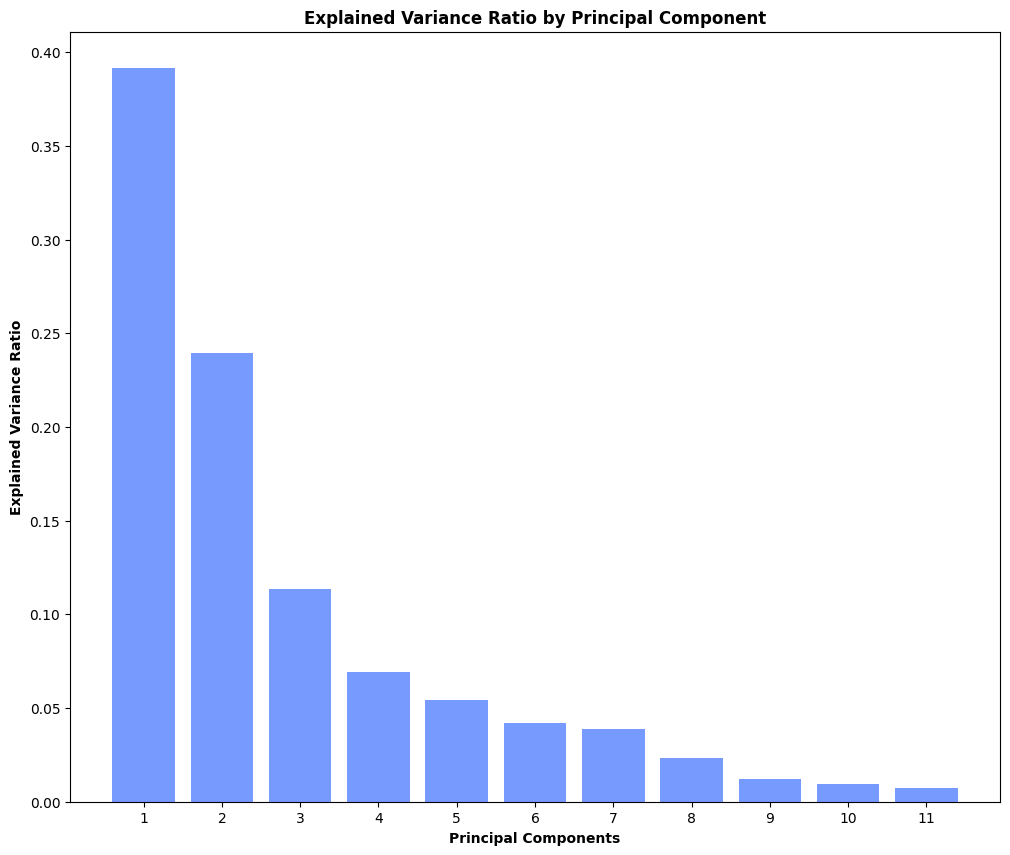

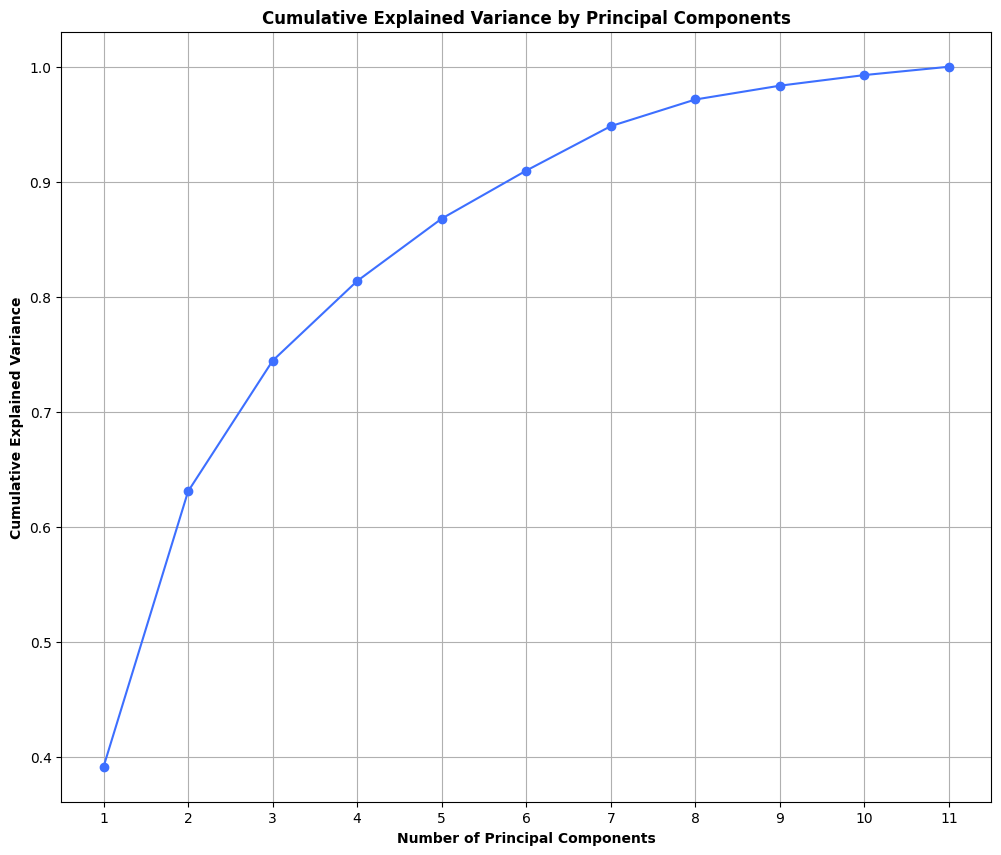

In [49]:
explained_variance = plot_PCA(X, (12,10), None, color= COLORS['PRETTY_BLUE'], alpha= 0.7, align= 'center')
plot_cumulative_explained_variance(explained_variance, (12, 10), None, marker='o', linestyle='-', color=COLORS['PRETTY_BLUE'])

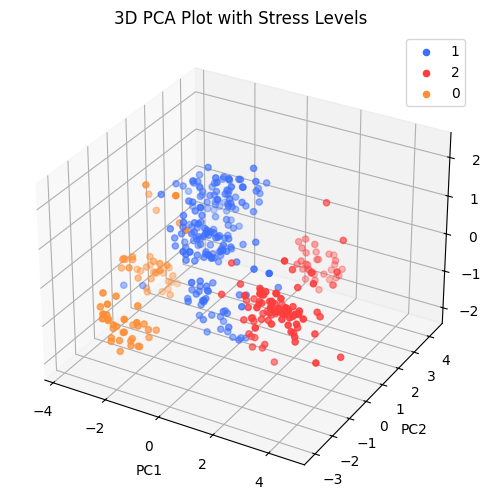

In [53]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# Create a new DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Stress Level'] = y  # Adding 'Stress Level' to the PCA DataFrame

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define unique categories in 'Stress Level'
categories = pca_df['Stress Level'].unique()

# Assign colors to categories
colors = [COLORS['PRETTY_BLUE'], COLORS['PRETTY_RED'], COLORS['PRETTY_ORANGE']]  # Add more colors if needed

for category, color in zip(categories, colors):
    subset = pca_df[pca_df['Stress Level'] == category]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], c=color, label=category, marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot with Stress Levels')
ax.legend()

plt.show()

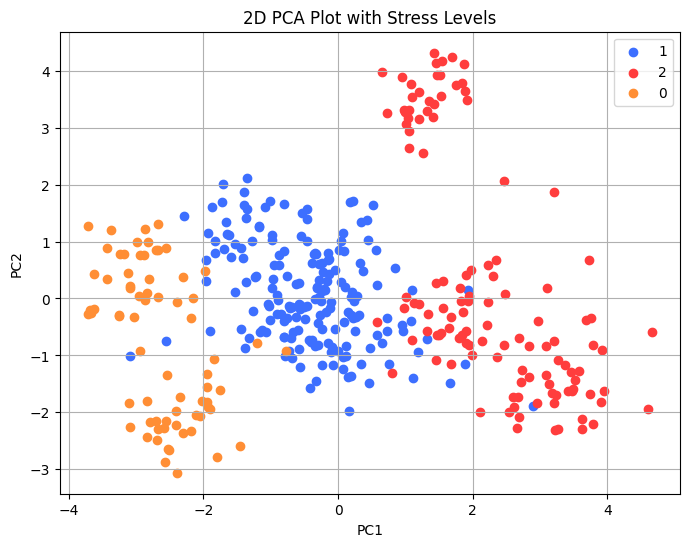

In [54]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Stress Level'] = y  

plt.figure(figsize=(8, 6))

categories = pca_df['Stress Level'].unique()

colors = [COLORS['PRETTY_BLUE'], COLORS['PRETTY_RED'], COLORS['PRETTY_ORANGE']]  # Add more colors if needed

for category, color in zip(categories, colors):
    subset = pca_df[pca_df['Stress Level'] == category]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=category, marker='o')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Plot with Stress Levels')
plt.legend()
plt.grid(True)
plt.show()

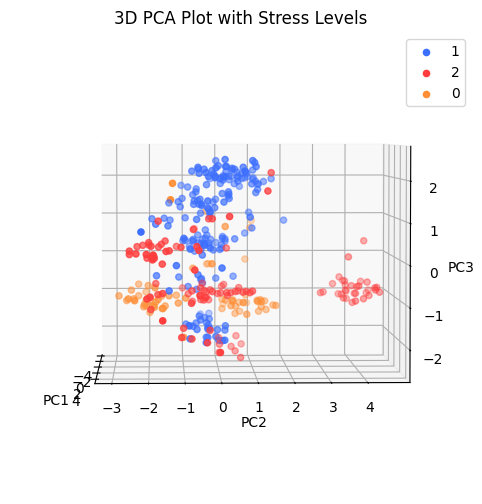

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation
from PIL import Image

# Assuming your DataFrame is named df_transformed with numerical values and 'Stress Level' column
X = df_transformed.drop(columns='Stress Level', axis=1)
y = df_transformed['Stress Level']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

# Create a new DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Stress Level'] = y  # Adding 'Stress Level' to the PCA DataFrame

# Create a function to update the plot for each frame
def update(frame):
    ax.view_init(elev=3., azim=frame)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define unique categories in 'Stress Level'
categories = pca_df['Stress Level'].unique()

# Assign colors to categories
colors = [COLORS['PRETTY_BLUE'], COLORS['PRETTY_RED'], COLORS['PRETTY_ORANGE']] 

for category, color in zip(categories, colors):
    subset = pca_df[pca_df['Stress Level'] == category]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], c=color, label=category, marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot with Stress Levels')
ax.legend()

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, 360, 2), interval=400)
ani.save('pca_rotation.gif', writer='pillow', fps=30)

plt.show()

Santé du cœur:

Fréquence cardiaque de jour
Fréquence cardiaque de nuit
Notifications de fréquence cardiaque élevée et basse
Variations de fréquence cardiaque de nuit*
*Fonctionnalité attendue pour Q4 2023

Suivi d’activité:

Zones de fréquence cardiaque en entraînement
Minutes actives
Nombre de pas
Calories brûlées
Connexion GPS : distance, allure & dénivelé

Suivi du sommeil:

Score de qualité du sommeil
Phases de sommeil (profond, léger)
Fréquence respiratoire*
Perturbations respiratoires
Durée du sommeil
Interruptions
Régularité

In [45]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import datasets
# from sklearn.model_selection import train_test_split, cross_val_predict
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# from sklearn.model_selection import cross_val_score
# from utilities import categorize_column
# #test algo ML 

# XX = df.copy()
# int_bins = [0, 4, 7, 11]
# categorial_labels = ['Not Stressed', 'Slighly Stressed', 'Stressed']
# categorize_column(XX,'Stress Level', int_bins, categorial_labels, handle_nan=True, drop_original=True, inplace= True)
# XX.rename(columns={'Stress Level_Bin': 'Stress Level'}, inplace=True)
# XX['Stress Level'] = XX['Stress Level'].map({'Not Stressed' : 0,'Slighly Stressed' : 1, 'Stressed' : 2})

# YY = XX['Stress Level']
# XX.drop(['Stress Level'], axis = 1, inplace = True)
# XX.drop(['Age'], axis = 1, inplace = True)
# X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size=0.33, random_state=42)
# ###
# rfc = RandomForestClassifier(n_estimators=100)
# rfc.fit(X_train, y_train)
# preds = rfc.predict(X_test)
# acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
# print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

# from sklearn.metrics import accuracy_score, classification_report
# # Importance des fonctionnalités (features)
# feature_importances = rfc.feature_importances_

# # Affichage de l'importance de chaque feature
# for feature, importance in zip(X_train.columns, feature_importances):
#     print(f"{feature}: {importance}")

#     # Création des données
# features = X_train.columns
# importances = feature_importances

# # Création de l'histogramme
# plt.figure(figsize=(10, 6))
# plt.bar(features, importances, color='skyblue')
# plt.title('Importance des fonctionnalités')
# plt.xlabel('Fonctionnalités')
# plt.ylabel('Importance')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# ###
# rfc_cv = RandomForestClassifier(n_estimators=100)
# scores = cross_val_score(rfc_cv, XX, YY, cv=10, scoring = "accuracy")
# print("Scores:", scores)
# print("Mean:", scores.mean())
# print("Standard Deviation:", scores.std())